In [15]:
import numpy as np
import pandas as pd
import mlflow
import warnings
import pickle
import sys, os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [16]:
# sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [17]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler

In [18]:
file_handler = FileHandler()
# reading the csv file
df = file_handler.read_csv("../data/BrentOil.csv")


In [19]:
data = df.groupby("Date").agg({"Price": "mean"})
data

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25


In [20]:
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))

In [21]:
data

array([[0.07067112],
       [0.0693363 ],
       [0.07007786],
       ...,
       [0.63144234],
       [0.64716352],
       [0.62654802]])

In [22]:
##splitting dataset into train and test split
training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:1]

In [23]:
training_size,test_size

(5857, 3154)

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [25]:
import numpy
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(5756, 100)
(5756,)


(None, None)

In [27]:
print(X_test.shape), print(ytest.shape)

(3053, 100)
(3053,)


(None, None)

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [30]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 9:08 6s/step - loss: 0.09 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.07 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.06 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.05 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.05 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.04 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - loss: 0.0462 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - loss: 0.043 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 0.041 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.038 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.037 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.035 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.033 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 0.032 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.031 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.030 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.029 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.028 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.027 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.026 ━━━

In [33]:
import tensorflow as tf

In [34]:
tf.__version__

'2.16.1'

In [35]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

180/180 ━━━━━━━━━━━━━━━━━━━━ 1:19 443ms/st ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step   ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/ste ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/s

In [36]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [37]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

40.391985467974706

In [38]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

80.84562400611324

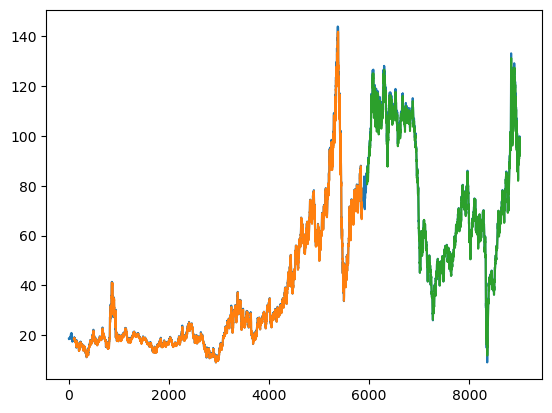

In [39]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [40]:
len(test_data)

3154

In [45]:
x_input=test_data[3054:].reshape(1,-1)
x_input.shape

(1, 100)

In [46]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [47]:
temp_input

[0.8028179458657768,
 0.8200964034111976,
 0.8387838338895068,
 0.8283277715980719,
 0.8207638116425658,
 0.8165368928439006,
 0.835743418613274,
 0.7518724508713385,
 0.7374119391916946,
 0.7734519836855765,
 0.7775305895439377,
 0.7842046718576196,
 0.7258435298479793,
 0.7272525027808676,
 0.7314794215795327,
 0.7649981460882462,
 0.8021505376344086,
 0.7850203930292917,
 0.7916944753429737,
 0.7690767519466073,
 0.7242862439747868,
 0.7351130886169819,
 0.7283648498331479,
 0.7455691509084168,
 0.7458657767890249,
 0.7594364108268447,
 0.7192436040044494,
 0.7223581757508343,
 0.6875787912495365,
 0.6591768631813125,
 0.6763811642565813,
 0.6997404523544679,
 0.7023359288097887,
 0.7116054875787913,
 0.7274008157211717,
 0.7015202076381164,
 0.661104931405265,
 0.6396737115313311,
 0.6534668149796069,
 0.6470152020763811,
 0.6477567667779014,
 0.6374490174267705,
 0.6703003337041157,
 0.6731182795698925,
 0.6652576937337783,
 0.682461994809047,
 0.6691879866518354,
 0.6484983314794

In [48]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.6177369]
101
1 day input [0.8200964  0.83878383 0.82832777 0.82076381 0.81653689 0.83574342
 0.75187245 0.73741194 0.77345198 0.77753059 0.78420467 0.72584353
 0.7272525  0.73147942 0.76499815 0.80215054 0.78502039 0.79169448
 0.76907675 0.72428624 0.73511309 0.72836485 0.74556915 0.74586578
 0.75943641 0.7192436  0.72235818 0.68757879 0.65917686 0.67638116
 0.69974045 0.70233593 0.71160549 0.72740082 0.70152021 0.66110493
 0.63967371 0.65346681 0.6470152  0.64775677 0.63744902 0.67030033
 0.67311828 0.66525769 0.68246199 0.66918799 0.64849833 0.61653689
 0.62284019 0.63121987 0.61053022 0.57641824 0.58502039 0.61238413
 0.62550983 0.61505376 0.62091212 0.59458658 0.59569892 0.5971079
 0.59888765 0.6028921  0.5575825  0.54467927 0.57004079 0.5965888
 0.59555061 0.59176863 0.60496848 0.62766036 0.63218391 0.64182425
 0.66577679 0.65279941 0.63826474 0.62543567 0.63819058 0.61638858
 0.60763812 0.59592139 0.60986281 0.61119763 0.61342232 0.61156841
 0.61297738 0.62165369 0.63084909 0.

In [49]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [50]:
import matplotlib.pyplot as plt

In [51]:
len(data)

9011

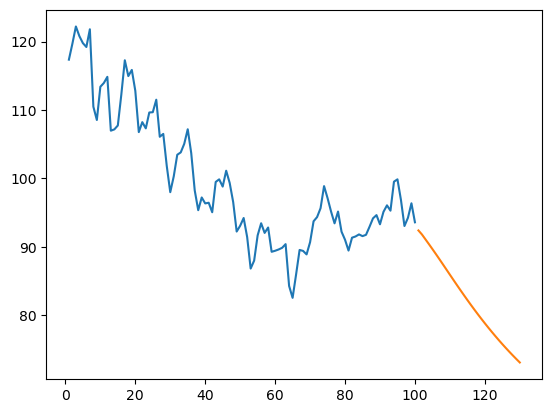

In [53]:
plt.plot(day_new,scaler.inverse_transform(data[8911:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

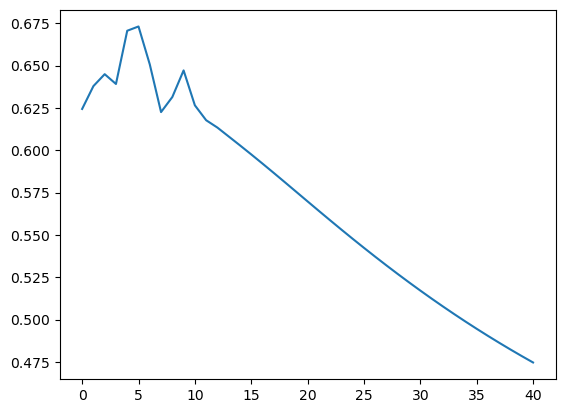

In [54]:
df3=data.tolist()
df3.extend(lst_output)
plt.plot(df3[9000:])

In [55]:
df3=scaler.inverse_transform(df3).tolist()

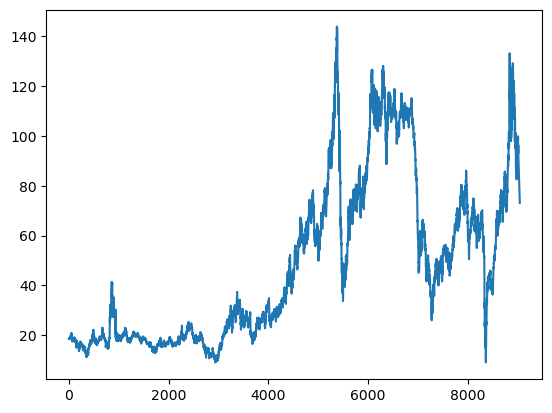

In [56]:
plt.plot(df3)

In [57]:
model.save('../models/LSTM.keras')